In [1]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.animation import FuncAnimation
import random
from enviroments import env_red, env_red_p2p, env_red_toy1, env_hubs0
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import action_space_generation, ini_action_list, caculate_op_cost,update_action_space
from algorithms.DQL import DQL_algorithm, select_action
from algorithms.QL_LowRank import select_action as select_action_LR



NUMERO_DE_NUCLEOS = 16

torch.set_num_threads(NUMERO_DE_NUCLEOS)


In [2]:
class Buffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def clear(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def __len__(self):
        return len(self.states)

In [3]:
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn

class SoftmaxAgent(nn.Module):
    def __init__(self, actor, critic, discretizer_actor=None, discretizer_critic=None) -> None:
        super(SoftmaxAgent, self).__init__()

        self.actor = actor
        self.critic = critic

        self.discretizer_actor = discretizer_actor
        self.discretizer_critic = discretizer_critic

    def pi(self, state: np.ndarray) -> torch.distributions.Normal:
        state = torch.as_tensor(state).double()

        # Parameters
        if self.discretizer_actor:
            state = state.numpy().reshape(-1, len(self.discretizer_actor.buckets))
            indices = self.discretizer_actor.get_index(state)
            logits = self.actor(indices).squeeze()
        else:
            logits = self.actor(state).squeeze()

        # Distribution
        pi = torch.distributions.categorical.Categorical(logits=logits)
        return pi

    def evaluate_logprob(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        # Actor
        dist = self.pi(state)
        action_logprob = dist.log_prob(action)
        return action_logprob.squeeze()

    def evaluate_value(self, state: torch.Tensor) -> torch.Tensor:
        # Critic
        if self.discretizer_critic:
            state = state.numpy().reshape(-1, len(self.discretizer_actor.buckets))
            indices = self.discretizer_critic.get_index(state)
            value = self.critic(indices)
            return value.squeeze()
        value = self.critic(state)
        return value.squeeze()

    def act(self, state: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        dist = self.pi(state)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        return action.detach().flatten(), action_logprob.detach().flatten()


In [4]:
from typing import Tuple, List

import numpy as np
import torch


class ReinforceSoftmaxNN:
    def __init__(
            self,
            actor,
            critic,
            discretizer_actor=None,
            discretizer_critic=None,
            gamma=0.99,
            tau=0.97,
            epochs: int=1000,
            lr_actor=1e-2,
        ):
        self.gamma = gamma
        self.tau = tau
        self.epochs = epochs

        self.buffer = Buffer()
        self.policy = SoftmaxAgent(actor, critic, discretizer_actor, discretizer_critic)
        self.opt_actor = torch.optim.Adam(self.policy.actor.parameters(), lr_actor)

        self.opt_critic = torch.optim.LBFGS(
            self.policy.critic.parameters(),
            history_size=100,
            max_iter=25,
            line_search_fn='strong_wolfe',
        )

    def select_action(self, state: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            state = torch.as_tensor(state).double()
            action, action_logprob = self.policy.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)

        return action.item()

    def calculate_returns(self, values) -> List[float]:
        returns = []
        advantages=[]

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(len(self.buffer.rewards))):
            reward = self.buffer.rewards[i]
            mask = 1 - self.buffer.terminals[i]

            actual_return = reward + self.gamma*prev_return*mask
            actual_delta = reward + self.gamma*prev_value*mask - values[i]
            actual_advantage = actual_delta + self.gamma*self.tau*prev_advantage*mask        

            returns.insert(0, actual_return)
            advantages.insert(0, actual_advantage)

            prev_return = actual_return
            prev_value = values[i]
            prev_advantage = actual_advantage

        returns = torch.as_tensor(returns).double().detach().squeeze()
        advantages = torch.as_tensor(advantages).double().detach().squeeze()
        advantages = (advantages - advantages.mean())/advantages.std()

        return returns, advantages

    def zero_grad(self, model, idx=None):
        if idx is None:
            return

        for i, param in enumerate(model.parameters()):
            if i != idx:
                param.grad.zero_()

    def update_critic(self, idx=None):
        states = torch.stack(self.buffer.states, dim=0).detach()

        # GAE estimation
        values = self.policy.evaluate_value(states)
        rewards, advantages = self.calculate_returns(values.data.numpy())

        # LBFGS training
        def closure():
            self.opt_critic.zero_grad()
            values = self.policy.evaluate_value(states)
            loss = (values - rewards).pow(2).mean()
            loss.backward()
            self.zero_grad(self.policy.critic, idx)
            return loss
        self.opt_critic.step(closure)

        return advantages

    def update_actor(self, advantages, idx=None):
        states = torch.stack(self.buffer.states, dim=0).detach()
        actions = torch.stack(self.buffer.actions, dim=0).detach().squeeze()

        # Stochastic Gradient Ascent
        for _ in range(self.epochs):
            logprobs = self.policy.evaluate_logprob(states, actions)
            loss_actor = -logprobs*advantages
            self.opt_actor.zero_grad()
            loss_actor.mean().backward()
            self.zero_grad(self.policy.actor, idx)
            self.opt_actor.step()

In [5]:
from typing import Tuple


class Trainer:
    def __init__(self, actor_opt, critic_opt):
        self.actor_opt = actor_opt
        self.critic_opt = critic_opt

    def _update(self, agent):
        if self.actor_opt == 'bcd':
            n_params_critic = len(list(agent.policy.critic.parameters()))
            for i in range(n_params_critic):
                advantages = agent.update_critic(i)
        else:
            advantages = agent.update_critic()

        if self.critic_opt == 'bcd':
            n_params_actor = len(list(agent.policy.actor.parameters()))
            for i in range(n_params_actor):
                agent.update_actor(advantages, i)
        else:
            agent.update_actor(advantages)

        agent.buffer.clear()

    def train(
        self,
        env,
        agent,
        epochs: int,
        max_steps: int,
        update_freq: int,
        initial_offset: int,
    ):
        returns = []
        timesteps = []
        favorable_routes = 0
        self.high_reward_states = []
        for epoch in range(epochs):
            state, _ = env.reset()
            cum_reward = 0

            for t in range(max_steps):
                action = agent.select_action(state)
                state_next, reward, done, _, _ = env.step(action)


                if t + 1 == max_steps:
                    done = True

                agent.buffer.rewards.append(reward)
                agent.buffer.terminals.append(done)
                cum_reward += reward

                if len(agent.buffer) >= update_freq and epoch > initial_offset:
                    self._update(agent)

                if done:
                    break

                state = state_next
            returns.append(cum_reward)
            timesteps.append(t)
            print(f'{epoch}/{epochs}: {returns[-1]}, Num. High rewuards \r', end='')
        return agent, returns, timesteps

In [6]:

class PolicyPARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0, model='gaussian'):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

        self.model = model
        if model == 'gaussian':
            self.log_sigma = torch.nn.Parameter(torch.zeros(1))

    def forward(self, indices):
        indices = indices.long()
        if len(indices.shape) == 1:
            indices = indices.view(1, -1)
        bsz = indices.shape[0]
        prod = torch.ones(bsz, self.k, dtype=torch.double)
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if indices.shape[1] < len(self.factors):
            res = torch.matmul(prod, self.factors[-1].T)
        else:
            res = torch.sum(prod, dim=-1)
        if self.model == 'gaussian':
            return res, torch.clamp(self.log_sigma, min=-2.5, max=0.0)
        return res


class ValuePARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

    def forward(self, indices):
        indices = indices.long()
        bsz = indices.shape[0]
        prod = torch.ones(bsz, self.k, dtype=torch.double)
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if indices.shape[1] < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)


In [11]:
env = env_hubs0(model="Exp", T=2000)

dimensions_actor = list(env.C + 1)
dimensions_actor.append(env.T+1)

dimensions_actor.extend([3]*33)


dimensions_critic = list(env.C + 1)
dimensions_critic.append(env.T+1)

freq = 5000

lr_actor = 1e-3

k = 5




In [9]:
Trainer = Trainer("sgd", "sgd")

In [14]:
actor = PolicyPARAFAC(dimensions_actor, k=k, model= "SoftMax", scale = 1)
critc = ValuePARAFAC(dimensions_critic, k=k, scale = 1)



agent = ReinforceSoftmaxNN(actor, critc,discretizer_actor=None,discretizer_critic=None, gamma=1, tau=1, lr_actor=lr_actor)


agent , totals,_ = Trainer.train(env, agent, epochs=7000, max_steps=300, update_freq=freq, initial_offset=0)

Rs = totals
mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b',label= "Exp")
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)
plt.grid()
plt.show()

ValueError: Expected parameter logits (Tensor of shape (5000, 3)) of distribution Categorical(logits: torch.Size([5000, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], dtype=torch.float64, grad_fn=<SubBackward0>)

In [11]:
env = env_hubs0(model="Exp", T=2000)

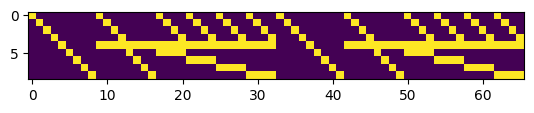

In [7]:
plt.imshow(env.A_ij)

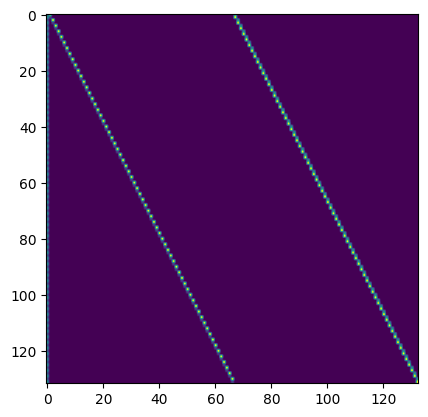

In [8]:
plt.imshow(env.v_lj)

In [14]:
class QfunPARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

    def forward(self, indices):
        bsz = indices.shape[0]
        prod = torch.ones(bsz, self.k, dtype=torch.double)
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if indices.shape[1] < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)


In [16]:
dims = list(env.C + 1)
dims.append(env.T+1)
dims.extend([2]*env.J)
qtensor = QfunPARAFAC(dims= dims, k = 5, scale= 0.1)
s, _ = env.set_initial(s = [0]*env.I)
a = qtensor(torch.tensor(np.array(s),dtype=torch.long).view(1, -1))
print(a)

torch.Size([1, 10])
tensor([[ 1.4029e-12, -7.7765e-13]], dtype=torch.float64,
       grad_fn=<MmBackward0>)


In [23]:
num_sim = 1000
max_steps = env.T

Rs = []
r_t= []
s_t = []
a_t = []

for episode in range(num_sim):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        a = 2**(env.J) - 1

        s_prime, r, done, _, _ = env.step(a)
            
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
                
        s = s_prime
    print(s)
    Rs.append(R)

[  55.   49.   49.   63.  150.   51.   59.   60.   53. 1998.]
[  62.   60.   67.   58.  150.   46.   48.   67.   59. 1998.]
[  55.   57.   75.   56.  150.   54.   62.   53.   66. 1998.]


KeyboardInterrupt: 

In [ ]:
env.action_space[0]

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [ ]:


print(action_space_generation(3, 2))

[(0, 1, 0), (0, 0, 0)]


In [ ]:
def action_space_generation(J,ini_num_actions):
    return random.sample(list(product([0,1], repeat=J)), ini_num_actions)

print(action_space_generation(10, 2))

[(1, 0, 0, 1, 0, 0, 1, 0, 0, 1), (0, 1, 0, 1, 1, 1, 1, 0, 0, 0)]


In [ ]:
def integer_to_binary_tuple(integer, word_size):
    # Obtener la representación binaria del número entero sin el prefijo '0b'
    binary_str = bin(integer)[2:]

    # Asegurarse de que la cadena binaria tenga el tamaño deseado llenando con ceros a la izquierda si es necesario
    binary_str = binary_str.zfill(word_size)

    # Crear una tupla con cada bit del número binario
    binary_tuple = tuple(int(bit) for bit in binary_str)

    return binary_tuple

# Ejemplo de uso:
numero = 10
tamaño_palabra = 8
binario = integer_to_binary_tuple(numero, tamaño_palabra)
print(f"El número {numero} en binario con tamaño de palabra {tamaño_palabra} es: {binario}")



El número 10 en binario con tamaño de palabra 8 es: (0, 0, 0, 0, 1, 0, 1, 0)


In [ ]:
A_ij = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
])

A_ij = np.concatenate((A_ij, A_ij), axis=1)

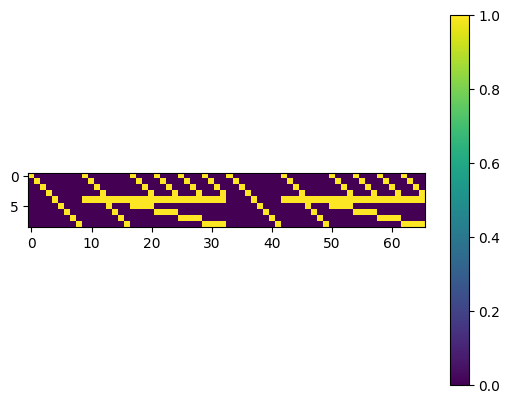

In [ ]:
plt.imshow(A_ij)
plt.colorbar()

In [ ]:
carpeta = "results/Exp5"
Demand_Model = "Exp"
Red_name = "red1"

In [ ]:
T = 400
env = env_red_toy1(Demand_Model,T)
# DQL
Qfun_model = "NN"
with open(carpeta +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    data = pickle.load(f)

qnet_exp = data["qfun_exp"]

#LRQL
Qfun_model = "LR"
with open(carpeta +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    data = pickle.load(f)
    
qtensor_exp = data["qfun_exp"]

In [ ]:
num_sim = 1000
max_steps = 400
Qfun = qtensor_exp[0]
model = "LR"

Rs = []
r_t= []
s_t = []
a_t = []

for episode in range(num_sim):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        if model == "NN":
            a = select_action(Qfun, s, 0, 2**(env.J))
        if model == "LR":
            a = select_action_LR(Qfun, s, 0,  2**(env.J))

        s_prime, r, done, _, _ = env.step(a)
            
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
                
        s = s_prime
    Rs.append(R)

IndexError: list index out of range

In [ ]:
def compare_Qfun(env, Qfun1, Qfun2, model1, model2):

    s_vecors = [range(0,c) for c in env.C]
    s_vecors.append(range(env.T-1))
    dif = 0  # Inicializar el máximo como negativo infinito
    
    for s_i in (product(*s_vecors)):

        s = torch.tensor(s_i, dtype=torch.double)

        if model1 == "NN":
            val1 = torch.max(Qfun1(s)).item()
        elif model1 == "LR":
            val1 = torch.max(Qfun1(torch.tensor(s_i, dtype=torch.long).view(1, -1))).item()

        if model2 == "NN":
            val2 = torch.max(Qfun2(s)).item()
        elif model2 == "LR":
            val2 = torch.max(Qfun2(torch.tensor(s_i, dtype=torch.long).view(1, -1))).item()

        dif += abs(val1-val2)

    return dif

In [ ]:
def compare_Qfun_exp(env,Qfun_list, model,name):
    data = np.zeros((len(Qfun_list), len(Qfun_list)))
    for q1 in range(len(Qfun_list)):
        for q2 in range(q1+1,len(Qfun_list)):
            diff = compare_Qfun(env, Qfun_list[q1], Qfun_list[q2], model, model)
            data[q1, q2] = diff
            data[q2, q1] = diff
    plt.imshow(np.array(data))
    plt.title("Diferencia en las funciones de valor")
    plt.xlabel("Exp1")
    plt.ylabel("Exp2")
    plt.colorbar()
    plt.savefig(name)

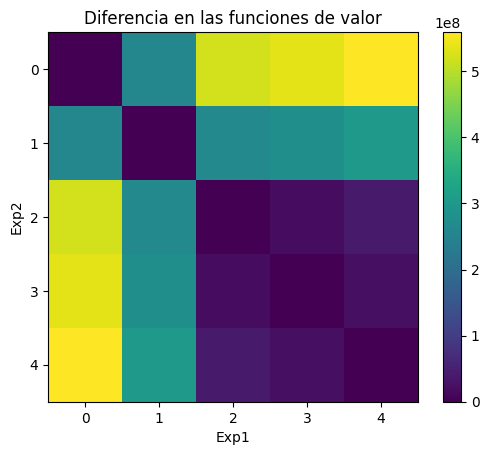

In [ ]:
compare_Qfun_exp(env,qnet_exp,"NN","Prueba")

In [ ]:
print(diff_matrix)

[[0.00000000e+00 2.59065887e+08 5.20095892e+08 5.37035516e+08
  5.59091145e+08]
 [2.59065887e+08 0.00000000e+00 2.62083752e+08 2.79219465e+08
  3.01322499e+08]
 [5.20095892e+08 2.62083752e+08 0.00000000e+00 1.80220941e+07
  3.98159048e+07]
 [5.37035516e+08 2.79219465e+08 1.80220941e+07 0.00000000e+00
  2.27477822e+07]
 [5.59091145e+08 3.01322499e+08 3.98159048e+07 2.27477822e+07
  0.00000000e+00]]


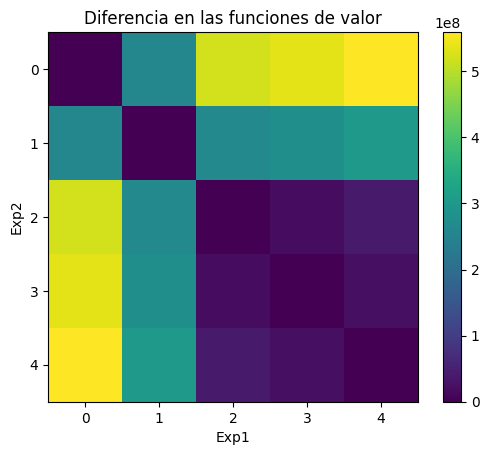

In [ ]:
plt.imshow(np.array(diff_matrix))
plt.title("Diferencia en las funciones de valor")
plt.xlabel("Exp1")
plt.ylabel("Exp2")
plt.colorbar()


In [ ]:
# DQL
env = env_red_toy()

nS = env.I + 1
nA =  2**(env.J)
nH = 128

qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
).double()

qnet.load_state_dict(torch.load("results/qnet_toy.pth"))

<All keys matched successfully>

In [ ]:
def get_toy_slide(qnet, t, states_map,C_1,C_2):
    t = 0
    data = np.zeros((len(C_1),len(C_2)))
    for (x1,x2) in (list(product(C_1,C_2))):
        idx = states_map[(x1,x2,t)]
        s = torch.tensor([x1,x2, t], dtype=torch.double)
        data[x1,x2] = torch.max(qnet(s))
    return data

Text(0, 0.5, 'Asientos vendidos, x1')

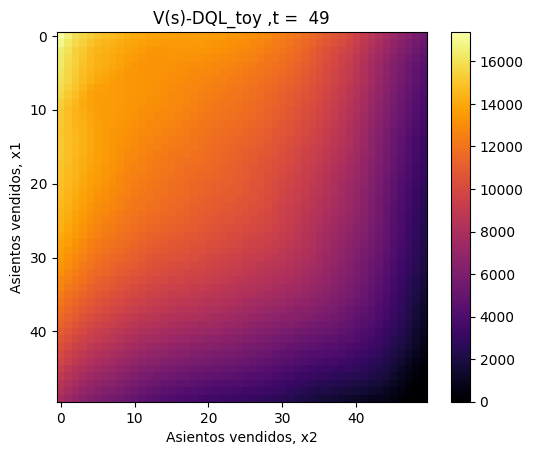

In [ ]:
C_1 = range(0,env.C[0])
C_2 = range(0,env.C[1])
T_RANGE = range(0,env.T)

states_map = {}

for idx, (x1,x2, t) in enumerate(list(product(C_1,C_2,T_RANGE))):
            states_map[(x1,x2, t)] = idx

vmax = torch.max(qnet(torch.tensor([0,0, 0], dtype=torch.double)))

data = get_toy_slide(qnet, t, states_map,C_1,C_2)

plt.imshow(data, cmap='inferno', interpolation='nearest',vmin=0, vmax=vmax)
    
plt.colorbar()  # Agregar barra de colores para referencia
plt.title(f'V(s)-DQL_toy ,t =  {t}')
plt.xlabel('Asientos vendidos, x2')
plt.ylabel('Asientos vendidos, x1')


In [ ]:
def get_tensor_from_net(qnet,env):
    dimensiones = [c for c in env.C]
    dimensiones.append(env.T)
    #dimensiones.append(len(env.action_space))

    tensor = torch.zeros(dimensiones)
    # Genera las combinaciones de índices usando itertools.product
    combinaciones = product(*(range(valor) for valor in dimensiones))

    # Itera sobre las combinaciones
    for combinacion in combinaciones:
        #tensor[combinacion] = qnet(torch.tensor(combinacion[:-1],dtype=torch.double))[combinacion[-1]]
        tensor[combinacion] = torch.max(qnet(torch.tensor(combinacion,dtype=torch.double)))
    return tensor

tensor = get_tensor_from_net(qnet,env)



tf.Tensor(3, shape=(), dtype=int32)


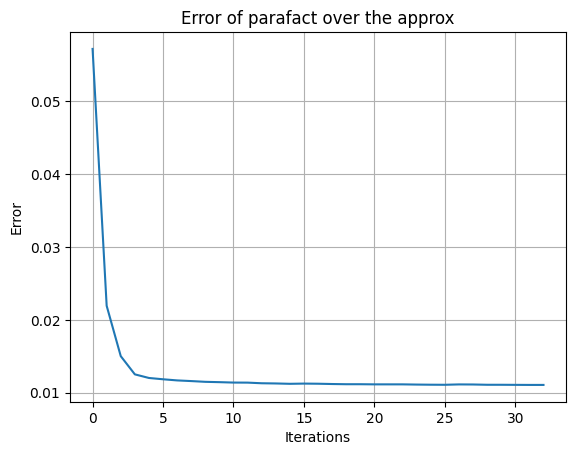

In [ ]:
rank = tf.rank(tensor.detach().numpy())
print(rank)

k = 5
# Realizar la descomposición PARAFAC
CPTensor, err = tl.decomposition.parafac(tensor.detach().numpy(),rank=k, return_errors = True)

factors = []
for factor in CPTensor.factors:
    factors.append(torch.tensor(factor))

plt.plot(err)
plt.grid()
plt.title("Error of parafact over the approx")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()


In [ ]:
def tensor_forward(factors,k,indices):
    bsz = indices.shape[0]
    prod = torch.ones(bsz, k, dtype=torch.double)
    for i in range(indices.shape[1]):
        idx = indices[:, i]
        factor = factors[i]
        prod *= factor[idx, :]
    if indices.shape[1] < len(factors):
        return torch.matmul(prod, factors[-1].T)
    return torch.sum(prod, dim=-1)




MovieWriter imagemagick unavailable; using Pillow instead.


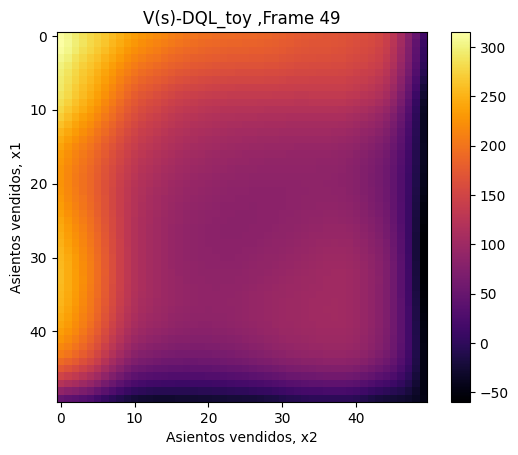

In [ ]:
# Función para generar datos de la imagen
def generate_data(frame):
    t = frame
    data = np.zeros((len(C_1),len(C_2)))
    for (x1,x2) in (list(product(C_1,C_2))):
        s = torch.tensor([x1,x2, t], dtype=torch.long).view(1, -1)
        data[x1,x2] =tensor_forward(factors,k,s)
    return data

# Función para la animación
def animate(frame):
    plt.clf()  # Limpiar el gráfico en cada frame
    data = generate_data(frame)
    plt.imshow(data, cmap='inferno', interpolation='nearest')
    
    plt.colorbar()  # Agregar barra de colores para referencia
    plt.title(f'V(s)-DQL_toy ,Frame {frame}')
    plt.xlabel('Asientos vendidos, x2')
    plt.ylabel('Asientos vendidos, x1')
    

# Crear la figura
fig, ax = plt.subplots()

# Crear la animación
animation = FuncAnimation(fig, animate, frames=50, interval=200)

# Guardar la animación en un archivo GIF
animation.save('DQL-to_tensor-reconstruida.gif', writer='imagemagick', fps=5)

# Mostrar el gráfico
plt.show()